# Efficient Frontiner from Modern Portfolio Theory implemented in Python

---

## Modern Portfolio Theory

Modern Portfolio Theory (MPT), developed by Harry Markowitz in the 1950s, is a widely accepted framework in finance that helps investors make informed decisions about constructing portfolios of assets. MPT is based on the premise that investors are primarily concerned with two key aspects of their investments: expected return and risk. The theory provides a mathematical approach to optimizing portfolios to achieve a desired level of return while managing risk effectively.

1. **Diversify to Reduce Risk:** MPT says that you shouldn't put all your money into just one investment (like one stock). Instead, you should spread your money across different types of investments (like stocks, bonds, and maybe other things) to reduce the risk that you'll lose a lot of money if one investment does badly.

2. **Balancing Risk and Reward:** MPT helps you find the right mix of investments that gives you a good chance of making money while also managing the risk of losing money. It's like finding a balance between taking some risks to get a good return and not taking too much risk.

3. **Optimizing Your Investments:** With MPT, you can calculate which combination of investments is likely to give you the best return for a certain level of risk. This helps you make more informed choices about where to put your money.

In a nutshell, Modern Portfolio Theory is a strategy for investing that suggests you diversify your investments, balance risk and reward, and use math to make smart choices. It's all about trying to maximize your chances of making money while also being careful about losing it.

In [2]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco
import os

np.random.seed(777)

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
# Load stock prices from CSV data in Risk folder
stock_prices_file = 'stock_prices.csv'

if os.path.exists(stock_prices_file):
    # Load real market data
    print("🔄 Loading stock price data from CSV...")
    df_prices = pd.read_csv('stock_prices.csv', index_col=0, parse_dates=True)
    
    # Select stocks from different sectors for better diversification:
    # AAPL - Technology (Apple)
    # JPM - Financials (JPMorgan Chase)
    # JNJ - Healthcare (Johnson & Johnson)
    # WMT - Consumer Staples (Walmart)
    stocks = ['AAPL', 'JPM', 'JNJ', 'WMT']
    sector_labels = ['Technology', 'Financials', 'Healthcare', 'Consumer Staples']
    
    # Check which stocks are available
    available_stocks = [stock for stock in stocks if stock in df_prices.columns]
    
    if len(available_stocks) < 3:
        print(f"⚠️  Only {len(available_stocks)} stocks available. Need at least 3.")
        print(f"Available: {available_stocks}")
        raise Exception("Insufficient stock data")
    
    # Use available stocks
    df_prices = df_prices[available_stocks]
    
    # Filter date range (use available data range)
    # Keep approximately 1-2 years of data for consistency
    if len(df_prices) > 504:  # If we have more than 2 years
        df_prices = df_prices.iloc[-504:]  # Use last 2 years
    
    print(f"✅ Loaded {len(available_stocks)} stocks from different sectors:")
    for stock, sector in zip(available_stocks, sector_labels[:len(available_stocks)]):
        print(f"   • {stock} - {sector}")
    print(f"📅 Date range: {df_prices.index[0].date()} to {df_prices.index[-1].date()}")
    print(f"📊 Total observations: {len(df_prices)}")
    
else:
    print("⚠️  stock_prices.csv not found in Risk folder")
    raise FileNotFoundError("Please ensure stock_prices.csv exists in the Risk folder")

🔄 Loading stock price data from CSV...
✅ Loaded 4 stocks from different sectors:
   • AAPL - Technology
   • JPM - Financials
   • JNJ - Healthcare
   • WMT - Consumer Staples
📅 Date range: 2023-09-01 to 2025-09-05
📊 Total observations: 504


In [4]:
# Create table with closing prices (similar structure to original)
table = df_prices.copy()

In [5]:
# Display the table (prices are already in the correct format)
print("Stock Prices:")
print(table.head())
print("...")
print(table.tail())

Stock Prices:
                                 AAPL         JPM         JNJ        WMT
Date                                                                    
2023-09-01 00:00:00-04:00  187.622253  140.072311  150.686646  52.626194
2023-09-05 00:00:00-04:00  187.859924  138.526764  150.874435  52.202759
2023-09-06 00:00:00-04:00  181.135788  138.297806  148.367401  52.593624
2023-09-07 00:00:00-04:00  175.837677  137.114777  150.264114  53.245064
2023-09-08 00:00:00-04:00  176.451645  137.219742  150.761780  53.342777
...
                                 AAPL         JPM         JNJ         WMT
Date                                                                     
2025-08-29 00:00:00-04:00  232.139999  301.420013  177.169998   96.980003
2025-09-02 00:00:00-04:00  229.720001  299.700012  178.059998   97.849998
2025-09-03 00:00:00-04:00  238.470001  299.510010  178.000000   99.440002
2025-09-04 00:00:00-04:00  239.779999  303.820007  178.759995  100.930000
2025-09-05 00:00:00-04:00  

In [6]:
table

,AAPL,JPM,JNJ,WMT
Date,,,,
2023-09-01 00:00:00-04:00,187.622253,140.072311,150.686646,52.626194
2023-09-05 00:00:00-04:00,187.859924,138.526764,150.874435,52.202759
2023-09-06 00:00:00-04:00,181.135788,138.297806,148.367401,52.593624
2023-09-07 00:00:00-04:00,175.837677,137.114777,150.264114,53.245064
2023-09-08 00:00:00-04:00,176.451645,137.219742,150.761780,53.342777
...,...,...,...,...
2025-08-29 00:00:00-04:00,232.139999,301.420013,177.169998,96.980003
2025-09-02 00:00:00-04:00,229.720001,299.700012,178.059998,97.849998
2025-09-03 00:00:00-04:00,238.470001,299.510010,178.000000,99.440002


<Axes: xlabel='Date'>

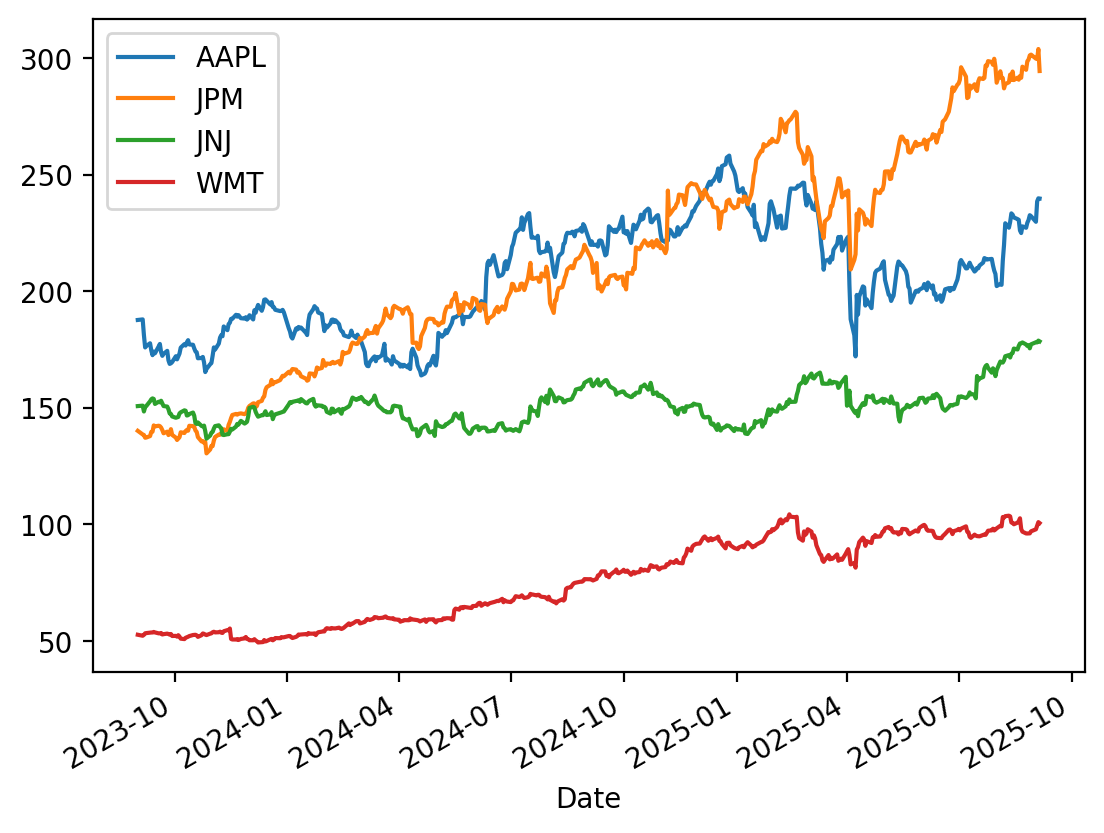

In [7]:
table.plot()

Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks' volatility.

<Axes: xlabel='Date'>

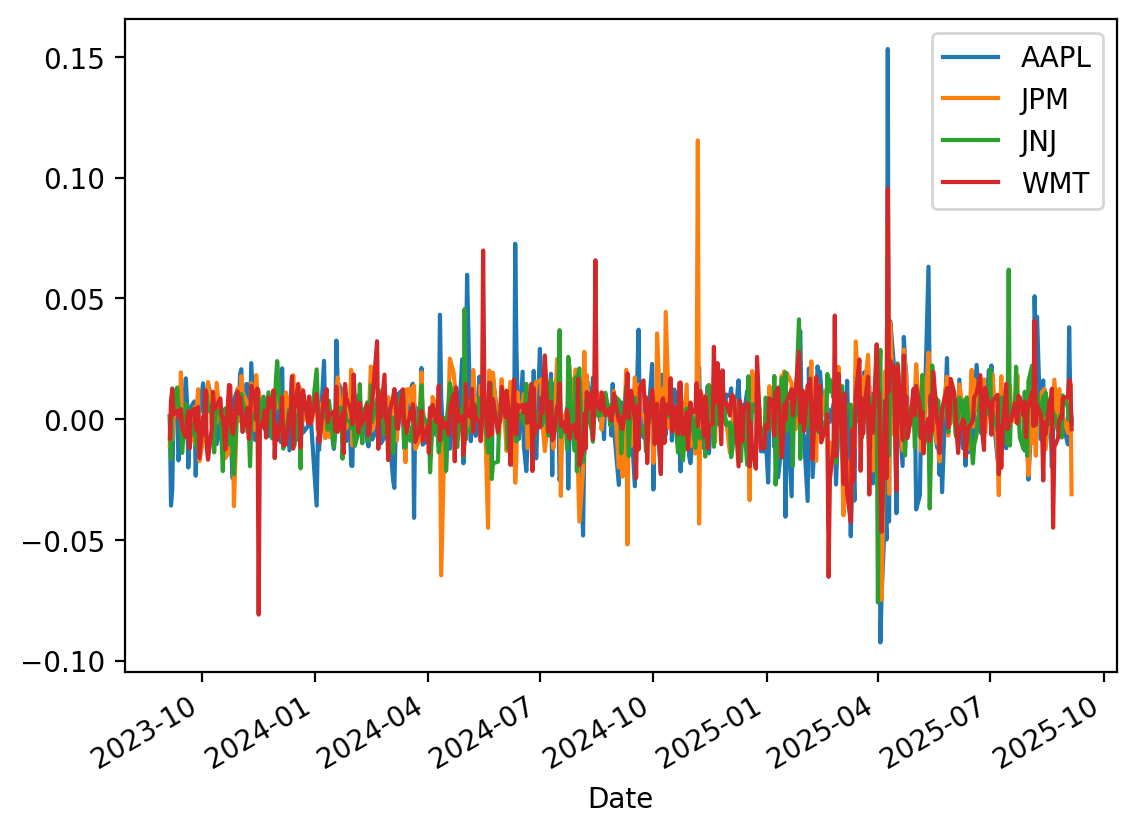

In [8]:
returns = table.pct_change()
returns.plot()

In [9]:
returns

,AAPL,JPM,JNJ,WMT
Date,,,,
2023-09-01 00:00:00-04:00,NaN,NaN,NaN,NaN
2023-09-05 00:00:00-04:00,0.001267,-0.011034,0.001246,-0.008046
2023-09-06 00:00:00-04:00,-0.035793,-0.001653,-0.016617,0.007487
2023-09-07 00:00:00-04:00,-0.029249,-0.008554,0.012784,0.012386
2023-09-08 00:00:00-04:00,0.003492,0.000766,0.003312,0.001835
...,...,...,...,...
2025-08-29 00:00:00-04:00,-0.001806,0.001163,0.009803,0.009052
2025-09-02 00:00:00-04:00,-0.010425,-0.005706,0.005023,0.008971
2025-09-03 00:00:00-04:00,0.038090,-0.000634,-0.000337,0.016249


---


#### Expected Return (Vector Form)

The expected return of a portfolio ($E(R_p)$) can be represented in vector form as:

$$E(R_p) = \mathbf{w}^T \cdot \mathbf{E}(R)$$

- $\mathbf{w}$ is a column vector of portfolio weights for each asset.
- $\mathbf{E}(R)$ is a column vector of expected returns for each asset.

#### Risk (Covariance Matrix)

The variance of a portfolio's returns ($Var(R_p)$) can be expressed using a covariance matrix:

$$Var(R_p) = \mathbf{w}^T \cdot \mathbf{\Sigma} \cdot \mathbf{w}$$

- $\mathbf{w}$ is the same portfolio weight vector as in the expected return equation.
- $\mathbf{\Sigma}$ is the covariance matrix of asset returns. The diagonal elements of this matrix represent the variances of individual assets, and the off-diagonal elements represent covariances between pairs of assets.



---

## Random Portfolios Generation

We have 4 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio's overall annualised returns and annualised volatility.

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [10]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [11]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    n_assets = len(mean_returns)  # Dynamic number of assets
    for i in range(num_portfolios):
        weights = np.random.random(n_assets)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

You can easily get daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. Finally, let's generate 25,000 portfolios with random weights assigned to each stock.

In [12]:
returns = table.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 25000
risk_free_rate = 0.0178

In [13]:
mean_returns

AAPL    0.000638
JPM     0.001586
JNJ     0.000396
WMT     0.001377
dtype: float64

In [14]:
cov_matrix

,AAPL,JPM,JNJ,WMT
AAPL,0.000305,0.000084,0.000009,0.000071
JPM,0.000084,0.000218,0.000025,0.000058
JNJ,0.000009,0.000025,0.000119,0.000018
WMT,0.000071,0.000058,0.000018,0.000181


Let me briefly explain what below function is doing. First, it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result. Then by locating the one with the highest Sharpe ratio portfolio, it displays maximum Sharpe ratio portfolio as red star sign. And does similar steps for minimum volatility portfolio, and displays it as the green star on the plot. All the randomly generated portfolios will be also plotted with colour map applied to them based on the Sharpe ratio. The bluer, the higher Sharpe ratio.

And for these two optimal portfolios, it will also show how it allocates the budget within the portfolio.

In [15]:
def display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.35
Annualised Volatility: 0.17


            AAPL    JPM   JNJ    WMT
allocation  0.07  45.66  6.81  47.47
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.13


             AAPL    JPM    JNJ    WMT
allocation  10.98  14.97  50.52  23.53


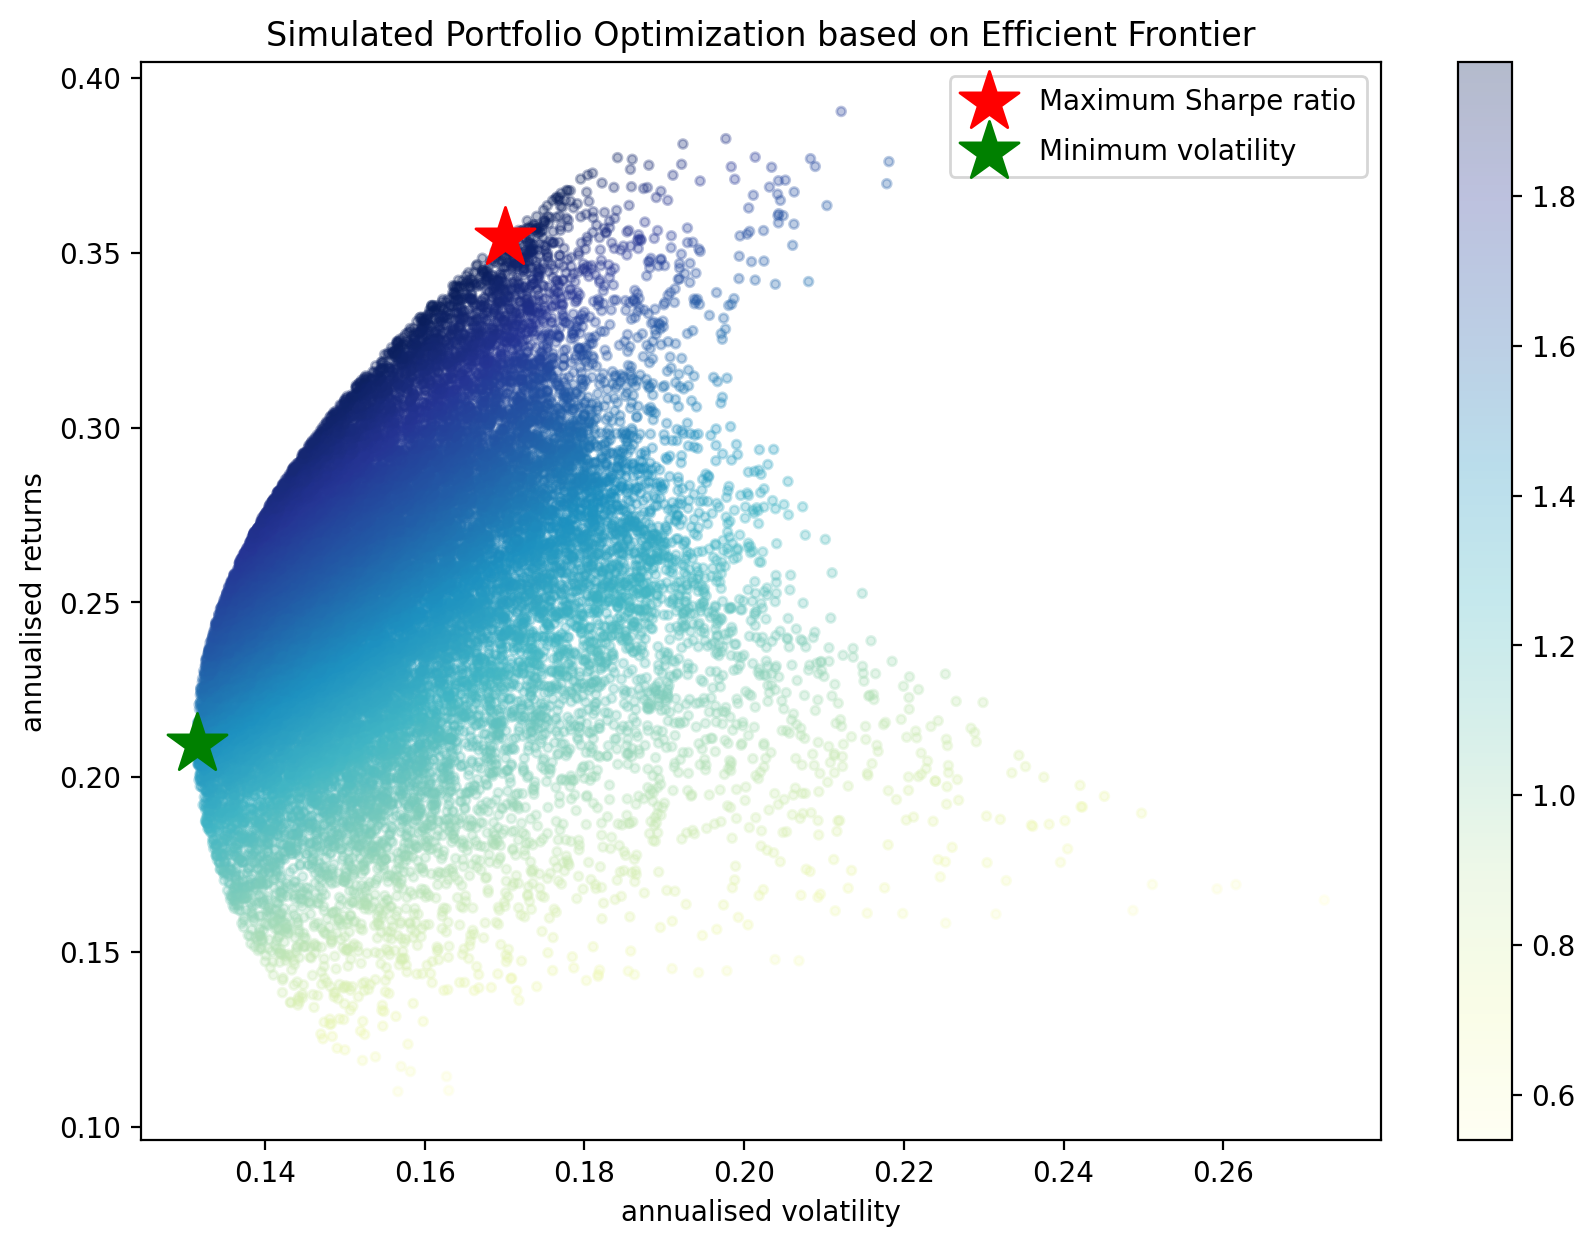

In [16]:
display_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

For minimum risk portfolio, we can see that more than half of our budget is allocated to Google. If you take another look at the daily return plot from earlier, you can see that Google is the least volatile stock of four, so allocating a large percentage to Google for minimum risk portfolio makes intuitive sense.

If we are willing to take higher risk for higher return, one that gives us the best risk-adjusted return is the one with maximum Sharpe ratio. In this scenario, we are allocating a significant portion to Amazon and Facebook, which are quite volatile stocks from the previous plot of daily returns. And Google which had more than 50% allocation in the minimum risk portfolio, has less than 1% budget allocated to it.

---

## Efficient Frontier

* From the plot of the randomly simulated portfolio, we can see it forms a shape of an arch line on the top of clustered blue dots. This line is called efficient frontier. Why is it efficient? Because points along the line will give you the lowest risk for a given target return. All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

* It is also known as the "Markowitz frontier," named after Harry Markowitz, who introduced the concept in his groundbreaking work on portfolio selection in 1952, for which he was awarded the Nobel Prize in Economics.

Below functions are to get the maximum Sharpe ratio portfolio. In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. In "max_sharpe_ratio" function, you first define arguments (this should not include the variables you would like to change for optimisation, in this case, "weights"). At first, the construction of constraints was a bit difficult for me to understand, due to the way it is stated. 

constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

The above constraint is saying that sum of x should be equal to 1. You can think of the 'fun' part construction as '1' on the right side of equal sign has been moved to the left side of the equal sign.

'np.sum(x) == 1' has become 'np.sum(x)-1'

And what does this mean? It simply means that the sum of all the weights should be equal to 1. You cannot allocate more than 100% of your budget in total.

"bounds" is giving another limit to assign random weights, by saying any weight should be inclusively between 0 and 1. You cannot give minus budget allocation to a stock or more than 100% allocation to a stock.

In [17]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

We can also define the optimizing function for calculating minimum volatility portfolio. This time we really do minimize the objective function. What do we want to minimize? We want to minimize volatility by trying different weights. "constraints" and "bounds" are same as the above.

In [18]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

As I already mentioned above we can also draw a line which depicts where the efficient portfolios for a given risk rate should be. This is called "efficient frontier". Below I define other functions to compute efficient frontier. The first function "efficient_return" is calculating the most efficient portfolio for a given target return, and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [19]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [20]:
def display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, _ = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0,:],results[1,:],c=results[2,:],cmap='YlGnBu', marker='o', s=10, alpha=0.3)
    plt.colorbar()
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.32, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.17


            AAPL    JPM   JNJ    WMT
allocation   0.0  46.73  6.56  46.71
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.13


             AAPL    JPM    JNJ    WMT
allocation  11.43  15.02  49.89  23.66


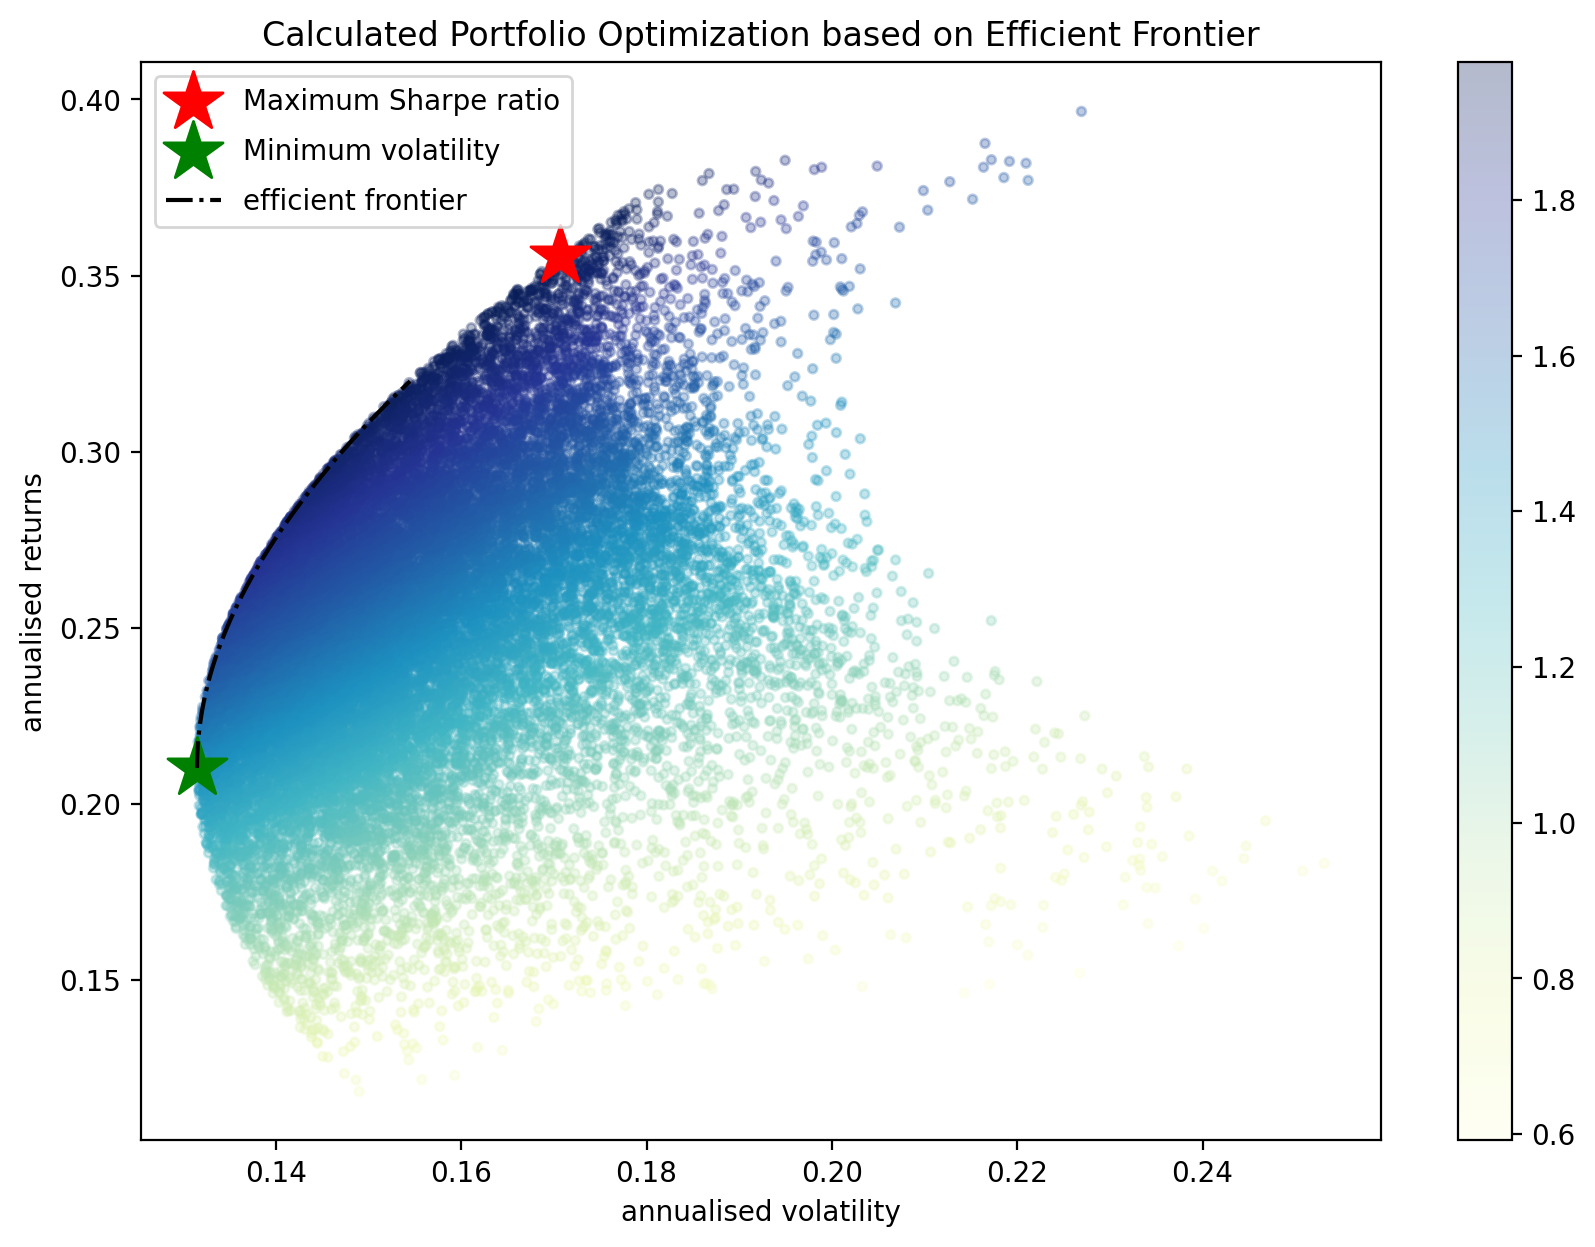

In [21]:
display_calculated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy's "optimize" function has not allocated any budget at all for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 0.45% of allocation for Google. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [22]:
def display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate):
    max_sharpe = max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate)
    sdp, rp = portfolio_annualised_performance(max_sharpe['x'], mean_returns, cov_matrix)
    max_sharpe_allocation = pd.DataFrame(max_sharpe.x,index=table.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    max_sharpe_allocation

    min_vol = min_variance(mean_returns, cov_matrix)
    sdp_min, rp_min = portfolio_annualised_performance(min_vol['x'], mean_returns, cov_matrix)
    min_vol_allocation = pd.DataFrame(min_vol.x,index=table.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    
    print ("-"*80)
    print ("Maximum Sharpe Ratio Portfolio Allocation\n")
    print ("Annualised Return:", round(rp,2))
    print ("Annualised Volatility:", round(sdp,2))
    print ("\n")
    print (max_sharpe_allocation)
    print ("-"*80)
    print ("Minimum Volatility Portfolio Allocation\n")
    print ("Annualised Return:", round(rp_min,2))
    print ("Annualised Volatility:", round(sdp_min,2))
    print ("\n")
    print (min_vol_allocation)
    print ("-"*80)
    print ("Individual Stock Returns and Volatility\n")
    for i, txt in enumerate(table.columns):
        print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
    print ("-"*80)
    
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.scatter(an_vol,an_rt,marker='o',s=200)

    for i, txt in enumerate(table.columns):
        ax.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')
    ax.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    ax.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')

    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    ax.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', color='black', label='efficient frontier')
    ax.set_title('Portfolio Optimization with Individual Stocks')
    ax.set_xlabel('annualised volatility')
    ax.set_ylabel('annualised returns')
    ax.legend(labelspacing=0.8)

d:\anaconda\envs\test2\Lib\site-packages\numpy\_core\fromnumeric.py:4062: FutureWarning: The behavior of DataFrame.std with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return std(axis=axis, dtype=dtype, out=out, ddof=ddof, **kwargs)
C:\Users\26891\AppData\Local\Temp\ipykernel_19020\2314151057.py:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print (txt,":","annuaised return",round(an_rt[i],2),", annualised volatility:",round(an_vol[i],2))
C:\Users\26891\AppData\Local\Temp\ipykernel_19020\2314151057.py:40: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior).

--------------------------------------------------------------------------------
Maximum Sharpe Ratio Portfolio Allocation

Annualised Return: 0.36
Annualised Volatility: 0.17


            AAPL    JPM   JNJ    WMT
allocation   0.0  46.73  6.56  46.71
--------------------------------------------------------------------------------
Minimum Volatility Portfolio Allocation

Annualised Return: 0.21
Annualised Volatility: 0.13


             AAPL    JPM    JNJ    WMT
allocation  11.43  15.02  49.89  23.66
--------------------------------------------------------------------------------
Individual Stock Returns and Volatility

AAPL : annuaised return 0.16 , annualised volatility: 0.28
JPM : annuaised return 0.4 , annualised volatility: 0.23
JNJ : annuaised return 0.1 , annualised volatility: 0.17
WMT : annuaised return 0.35 , annualised volatility: 0.21
--------------------------------------------------------------------------------


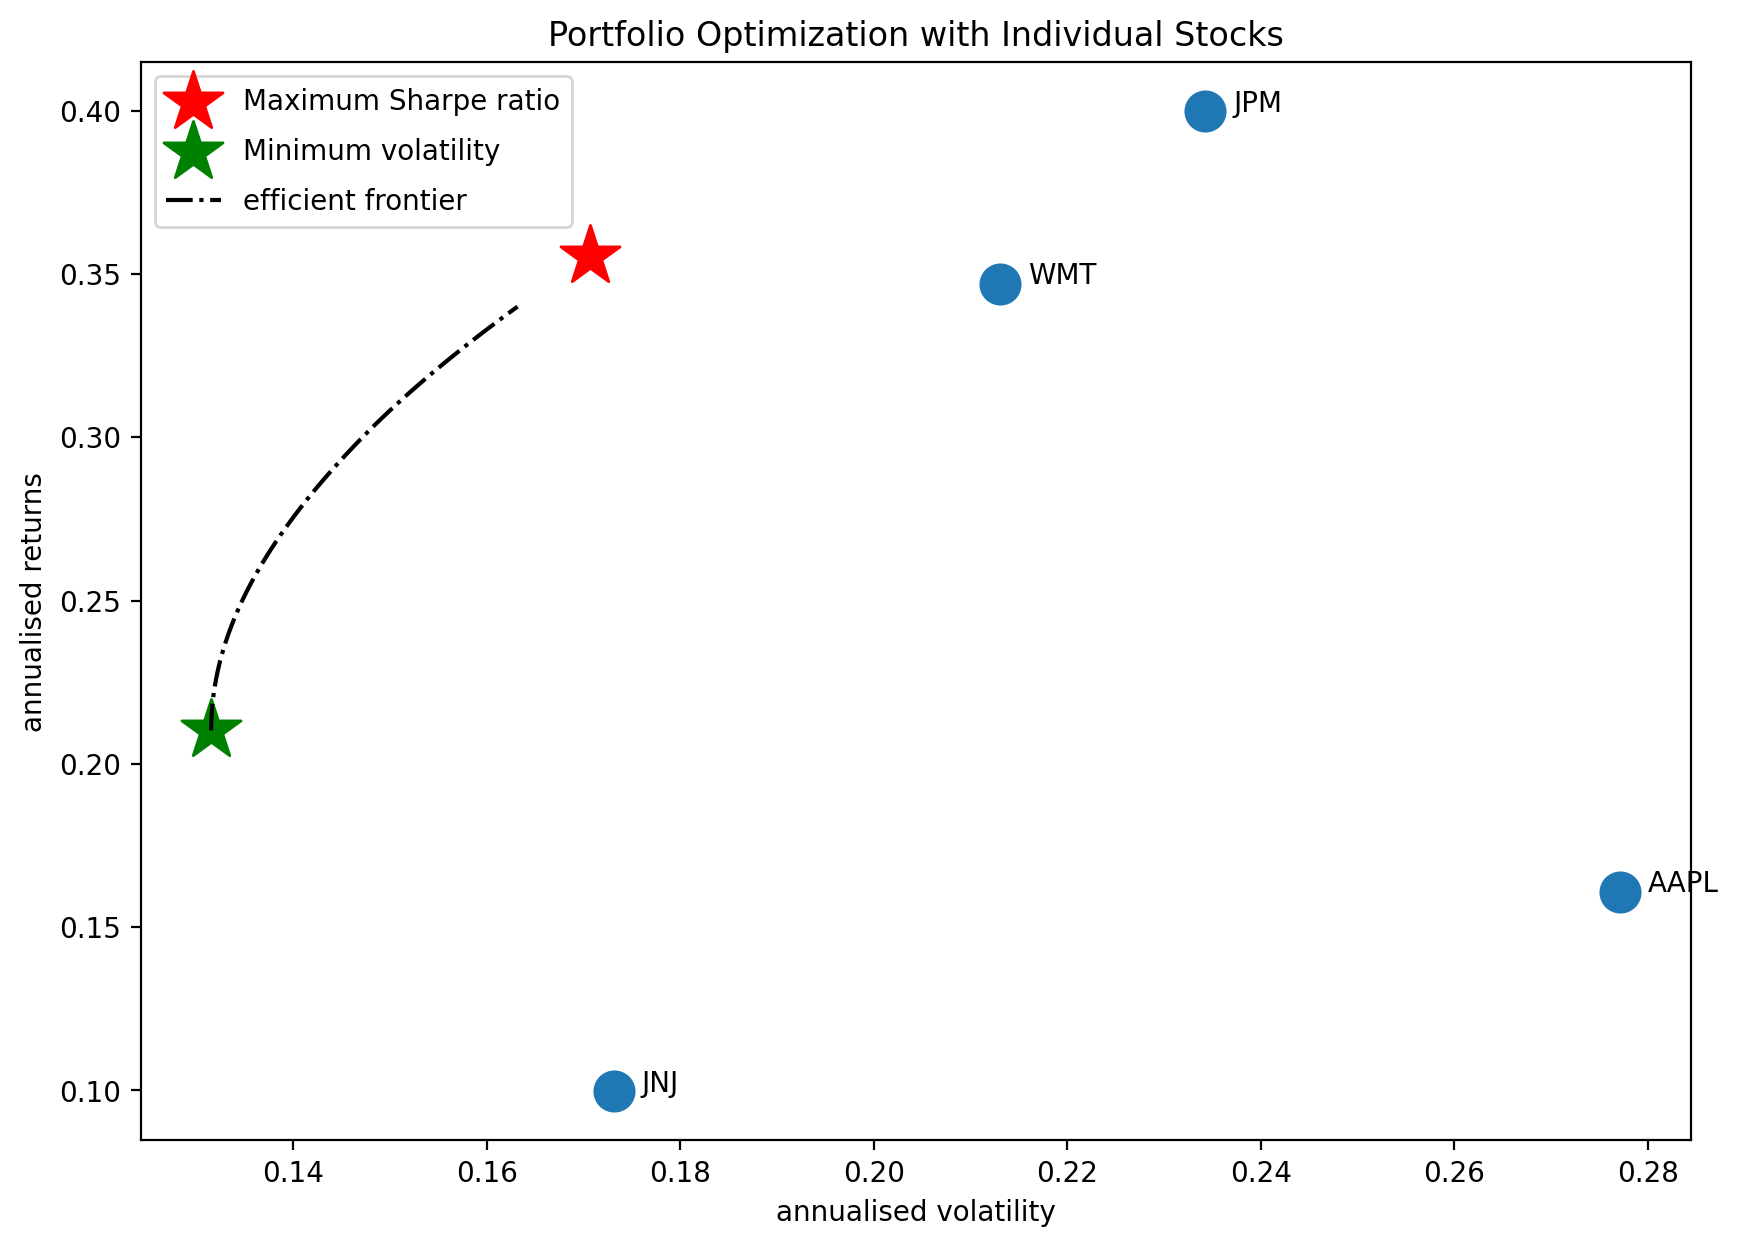

In [23]:
display_ef_with_selected(mean_returns, cov_matrix, risk_free_rate)

As you can see from the above plot, the stock with the least risk is Google at around 0.18. But with portfolio optimisation, we can achieve even lower risk at 0.16, and still with a higher return than Google. And if we are willing to take slightly more risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimization.

Considering how vast and deep the finance field is, I've probably only scratched the surface. But I had fun going through coding and trying to understand the concept. And I'm learning every day. After finishing this implementation, I definitely know better than yesterday's me. And if I keep on going and learning, in about a couple of year's time, I will know a whole lot more than today's me. If you have any comments or questions, feel free to leave a comment. Any feedback would be appreciated.

---

## Capital Market Line 

The Capital Market Line can be expressed in vector form as:

$$E(R_p) = R_f + \frac{E(R_m) - R_f}{\sigma_m} \cdot \sigma_p$$

- $\mathbf{E}(R_p)$ is a vector of expected returns for portfolios on the CML.
- $R_f$ is a scalar representing the risk-free rate.
- $\mathbf{E}(R_m)$ is a scalar representing the expected return of the market portfolio.
- $\sigma_m$ is a scalar representing the standard deviation of the market portfolio.
- $\sigma_p$ is a vector of standard deviations for portfolios on the CML.

1. **Graphical Representation**: The CML is a straight line on a graph that shows the expected return and risk (standard deviation of returns) of a portfolio that includes a combination of a risk-free asset (such as government bonds) and a risky asset (such as a diversified stock portfolio).

2. **Efficient Portfolios**: The CML represents a set of efficient portfolios that provide the highest return for a given level of risk or the lowest risk for a given level of return.

3. **Optimal Portfolio**: The point where the CML is tangent to the efficient frontier (a set of portfolios with the highest return for a given level of risk) represents the optimal portfolio for an investor, considering their risk preferences.

---

## Resources

Series of Medium blog post by Bernard Brenyah (https://medium.com/@bbrenyah)
- Markowitz’s Efficient Frontier in Python [Part 1/2] (https://medium.com/python-data/effient-frontier-in-python-34b0c3043314)
- Markowitz’s Efficient Frontier in Python [Part 2/2] (https://medium.com/python-data/efficient-frontier-portfolio-optimization-with-python-part-2-2-2fe23413ad94)

Blog post by Bradford Lynch (http://www.bradfordlynch.com/)
- Investment Portfolio Optimization (http://www.bradfordlynch.com/blog/2015/12/04/InvestmentPortfolioOptimization.html)